In [ ]:
# Install the required libraries
!pip install prophet

In [1]:
# Dependencies
# NOTE: We might not use all of these. I just improrted everything I can think of for now. We'll delete the ones we don't need later
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json
import path

In [10]:
#Read data into the notebook
linkedin_postings_df = pd.read_csv('./data_sets/postings.csv').dropna()
machine_learning_jobs_df = pd.read_json('./data_sets/job_data.json', lines=True)

# Normalize, clean, massage, and combine data for ease of processing

# Cast all job skills to lower case strings to standardize string matching later
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills'].apply(lambda item: item.lower())

***Introduction*** 
The goal of this exploratory data analysis is to characterize and investigate the growth of machine learning as a job skill. We are interested in looking at this topic along a number angles. TBC....
Our dataset includes 9367 job postings takend from linkedin for the 2023 calendar year. 

QUESTION Geography 

In [ ]:
# Insert Question 1 analysis and visualizations here. Insert new cells if necessary 

Q1 Summary \[INSERT SUMMARY HERE] ... write a little about what the findings above seem to indicate about question 1

**Section 2: Relative Comparisons of Tech Workers with/without Machine Learning **
Another dimension by which to look at the growth of machine learning is to compare software developers *with* ML experience to those *without* machine learning experience. Layoffs among general tech workers have been pronounced in recent months [Link](https://layoffs.fyi/) yet demand for Machine Learning engineers has reportedly increased 42% on Hired's platform [Link](https://hired.com/resources/articles/trends-software-engineer-specializations/) . This demonstrates that as a specialization, ML ought to be treated separately from other tech skills.

***Basic metrics***
As a firsts step, we compare the relative proportion of machine learning related job listings to those lacking that term. We achieve this by doing a string match through the data set using a common list of ML related terms.

In [70]:
# Get all job listings with an AI related keyword  listed as a skill requirement 
terms_to_match = ['machine learning', 'artificial intelligence', 'pytorch', 'langchain', 'ai', 'tensorflow', 'deep learning', 'neural network', 
               'natural language processing', 'nlp', 'computer vision', 'large language models', 'llm', 'llms', 'generative ai', 'generative models', 'genai', 'bert', 'spacy', 'nltk', 'keras', 'gpt', 'chatgpt', 'prompt development', 'prompt engineering']

linkedin_postings_df['has_ai'] = linkedin_postings_df['job_skills'].apply(
    lambda skills: any(term in skills for term in terms_to_match)
)
#Separate the groupings into two new dataframes
ai_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == True]
# Job listings without AI keywords will be classified as "general" roles
general_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == False]

Relative proportion of ML jobs to non-ML SWE jobs

In [78]:
# Raw counts of ML to non-ML
display(linkedin_postings_df['has_ai'].value_counts())
display(ai_roles.shape)
# Proportion of ML to non-ML
display(linkedin_postings_df['has_ai'].value_counts(normalize=True))

has_ai
False    6566
True     2801
Name: count, dtype: int64

(2801, 14)

has_ai
False    0.700971
True     0.299029
Name: proportion, dtype: float64

Given that x of the y job listings contain an AI related keyword, approximately z% of all listings are AI-related to some degree.

Another dimension we want to investigate is the relative proportion of job levels, or experience requirements. Considering that AI is a newer skill set, we predict a greater proportion of entry level positions compared to generic tech roles based on skills that have been around longer.

In [72]:
print(ai_roles['job level'].value_counts(normalize=True))
print(general_roles['job level'].value_counts(normalize=True))

job level
Mid senior    0.866476
Associate     0.133524
Name: proportion, dtype: float64
job level
Mid senior    0.86293
Associate     0.13707
Name: proportion, dtype: float64


We find that at least for this data set, the relative demand for associate versus mid-senior level developers for AI is almost identical to the relative demand of the same for general developers. Notably, demand for mid-senior is slightly lower for ML-related jobs, although it remains to be seen if this is statistically significant. 

Next, within the AI subset, we wanted to see which skills were most in demand. For this we will take our list of AI related job skill keywords and construct a new dataframe with a dictionary using the keywords as keys and the frequencies as values.  

In [76]:
# Use a list comprehension and the dict method to turn tuples into key value pairs
keyword_dict = dict([(keyword, 0) for keyword in terms_to_match])
# Count the frequencies the terms appear in each skill set
def increment_terms(term_list:list): 
    for skill in term_list:
        if skill in keyword_dict:
            keyword_dict[skill] += 1
    return term_list
ai_roles['job_skills'].apply(lambda skills: increment_terms(skills.split(', ')))
#Convert dict to series 
skill_series = pd.Series(keyword_dict)

# Here we de-duplicate different keyword lables and sum them together 
label_mapping = {'artificial intelligence': 'ai', 'natural language processing': 'nlp', 'large language models': 'llms', 'llm': 'llms', 'generative models' : 'genai', 'generative ai': 'genai'}

# Replace the labels in the series index
skill_series.index = skill_series.index.to_series().replace(label_mapping)

# Aggregate the data - sum the values with the same label
skill_series = skill_series.groupby(skill_series.index).sum()

# Display the resulting series
print(skill_series)

ai                    350
bert                    1
chatgpt                 7
computer vision       101
deep learning          61
genai                  65
gpt                     1
keras                   5
langchain              12
llms                   44
machine learning      642
neural network          2
nlp                   103
nltk                    0
prompt development      0
prompt engineering     14
pytorch                57
spacy                   0
tensorflow             68
dtype: int64


<Axes: >

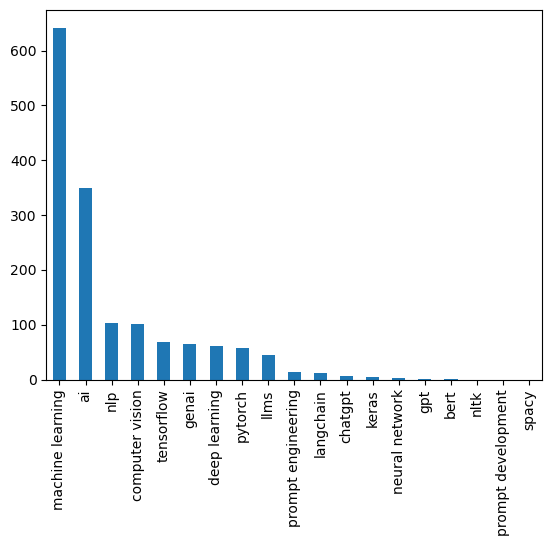

In [77]:
skill_series.sort_values(ascending=False).plot(kind='bar')

Q2 Summary \[INSERT SUMMARY HERE]

Geographic Distributions: 

In [ ]:
# Some geography related pre-processing

# Get the initials of each state
state_abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ]
def get_location(location_str: str):
   # Note: because the job_location field is inconsistent in the data set, we need to do a little data preparation  
    if location_str[-2:] == 'om':
        #handle British jobs  as the last two characters means United Kingd*om
        return 'UK'
    elif location_str[-2:] == 'da':
        #handle Canadian jobs 
        return 'CAN'
    elif not any(location_str[-2:] == abbreviation for abbreviation in state_abbreviations):
        # Handle the situation where the string is too heterogenous to classify within reasonable bounds
        return "N/A"
    else :
        #Otherwise simply return the state abbreviation 
        return location_str[-2:]

linkedin_postings_df['job_state'] = linkedin_postings_df['job_location'].apply(lambda item: get_location(item))


Question Job Skills

In [ ]:
# etc 

Q3 Summary \[INSERT SUMMARY HERE]

Question Seniority/Job level

In [ ]:
# etc 

Question 5 Industry demand 